### 참고

- 넷플릭스
    - 슬로건 : 모든 것이 추천이다.
    - https://medium.com/netflixtechblog/55838468f429
    - 넷플릭스의 추천 알고리즘 구현에 대한 기술 블로그 공개

### 1. 연구 목표

- 사용자 평점 데이터를 기반으로 사용자 특정을 예측하여 추천 시스템을 구축한다.
- 실제 OTT, 쇼핑몰에서 회원가입 시 추천 알고리즘으로 사용된다.
- 회귀 처리, 회귀 평가, 추천시스템에 대한 이해
- FastFM(third party 알고리즘 사용 -> 인수분해머신 기능 지원)
    - 윈도우에서 컴파일 후 설치가 불가능하므로 리눅스에 설치하여 개발을 진행

### 2. 데이터 수집/확보

- ml-100k.zip 파일 제공
    - 미국에 있는 movelens라는 사이트에서 제공
- 영화 정보 데이터
    - 고객 정보 : u.user
    - 영화 정보 : u.item
    - 평점 정보 : u.data

In [1]:
import pandas as pd

In [2]:
# 유저 정보 : u.user
# u.user라는 데이터에 컬럼이 없다보니, 첫번째 데이터가 컬럼이 되었다.
# 이를 예방하기 위해서는 컬럼을 지정한다.
cols = ['uid', 'age', 'm', 'job', 'zip_code']
users = pd.read_csv('./table/ml-100k/u.user', sep='|', names=cols)

In [3]:
users.head(2)

,uid,age,m,job,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [4]:
users.tail(2)

,uid,age,m,job,zip_code
941,942,48,F,librarian,78209
942,943,22,M,student,77841


In [5]:
# 고객 943명의 데이터
users.shape

(943, 5)

In [6]:
# 영화 정보 로드 : u.item
m_cols = ['mid', 'title', 'release_date', 'video_release_date', 'imdb_url']

# 영어권이라면 utf-8에서 에러나면 latin1으로 사용
# 원본 데이터의 컬럼이 많은데 부분만 쓰고 싶다면 usecols를 적용
movies = pd.read_csv('./table/ml-100k/u.item', sep='|', encoding='latin1', names=m_cols, usecols=range(5))
movies.head(2)

,mid,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...


In [7]:
movies.tail(2)

,mid,title,release_date,video_release_date,imdb_url
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...


In [8]:
movies.shape

(1682, 5)

In [9]:
movies.isnull().sum()

mid                      0
title                    0
release_date             1
video_release_date    1682
imdb_url                 3
dtype: int64

In [10]:
# 평점 정보 : u.data
r_cols = ['uid', 'mid', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./table/ml-100k/u.data', sep='\t', names=r_cols)
ratings.head(2)

,uid,mid,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742


In [11]:
ratings.tail(2)

,uid,mid,rating,unix_timestamp
99998,13,225,2,882399156
99999,12,203,3,879959583


In [12]:
ratings.shape

(100000, 4)

In [13]:
ratings.isnull().sum()

uid               0
mid               0
rating            0
unix_timestamp    0
dtype: int64

In [14]:
# unix_timestamp는 1970년 1월 1일 00시 00분 00초 부터 현재까지 경과된 시간 + 09:00
# 그래서 현재시간 특정시간을 특정하기가 어렵다. -> 해석이 어렵다. -> 시간형식 변경
ratings['date'] = pd.to_datetime(ratings.unix_timestamp, unit='s')
ratings.head(2)

,uid,mid,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22


In [15]:
ratings.tail(2)

,uid,mid,rating,unix_timestamp,date
99998,13,225,2,882399156,1997-12-17 22:52:36
99999,12,203,3,879959583,1997-11-19 17:13:03


In [16]:
ratings.shape

(100000, 5)

In [17]:
# 3. 데이터 준비/품질향상/전처리
# 4. 데이터 분석/통계적, 시각적, ...

In [18]:
# 평점과 영화 데이터 합치기
# 합친 결과 -> 100000, 9
# merge()를 수행할 때 중복되는 컬럼을 생략하면 알아서 찾아서 수행된다.
movies_ratings = pd.merge(movies, ratings, on='mid')
movies_ratings.head(2)

,mid,title,release_date,video_release_date,imdb_url,uid,rating,unix_timestamp,date
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,287,5,875334088,1997-09-27 04:21:28


In [19]:
movies_ratings.tail(2)

,mid,title,release_date,video_release_date,imdb_url,uid,rating,unix_timestamp,date
99998,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,896,3,887160722,1998-02-11 01:32:02
99999,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,916,3,880845755,1997-11-29 23:22:35


In [20]:
movies_ratings.shape

(100000, 9)

In [21]:
# movies_ratings, user -> 합치기
movie_lens = pd.merge(movies_ratings, users)
movie_lens.head(2)

,mid,title,release_date,video_release_date,imdb_url,uid,rating,unix_timestamp,date,age,m,job,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076


In [22]:
movie_lens.tail(2)

,mid,title,release_date,video_release_date,imdb_url,uid,rating,unix_timestamp,date,age,m,job,zip_code
99998,894,Home Alone 3 (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,729,1,893286511,1998-04-22 23:08:31,19,M,student,56567
99999,901,Mr. Magoo (1997),25-Dec-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,729,1,893286491,1998-04-22 23:08:11,19,M,student,56567


In [23]:
movie_lens.shape

(100000, 13)

- 데이터를 모두 병합하였다. 평점이나 회원을 중심으로 중복적인 데이터가 많다.
- 데이터가 적으면 크게 문제 없으나, 크면 메모리를 많이 사용할 수도 있다.(검토)

In [24]:
# 평가를 가장 많이 받은 영화 상위 10개 출력
# mid나 title 둘 다 사용이 가능하나, 결과를 이해하기 위해서 title을 사용
movie_lens.title.value_counts()[:10]

Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: title, dtype: int64

In [25]:
# 평점을 받은 횟수가 적은 경우, 우연히 평점이 좋을수도 있다.
# 데이터를 조정할 때, 특정 횟수(임계치) 이상 평가한 작품만 고려하였다.

- 제목 기준으로 데이터를 분류
- 평가의 개수, 평균 평점이 들어가있는 df
- 인덱스 : tilte, 컬럼 : 개수, 평균평점 <- 만드는 과정에서 컬럼의 레벨이 1이상이 되고 관계없음)

In [26]:
import numpy as np

In [27]:
# groupby(컬럼) : 해당 컬럼이 인덱스로 이동
# agg({컬럼: [값 처리 함수...]}) : 컬럼에 처리 함수 개수대로 설정되서 값이 자동 처리
movie_state = movie_lens.groupby('title').agg({'rating': [np.size, np.mean]})
movie_state.head(2)

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000

In [28]:
# 이 케이스에서는 피벗의 표현이 좀 더 복잡할 수 있어서 배제
# movie_lens.pivot_table()

- 평점을 받은 개수가 1개인 경우, 소수의 평가를 받은 영화
- 평균의 수가 적으면 잡음의 개입 여지가 많다.
- 100건 기준으로 100개 이상만 대상으로 처리(임계값)

In [29]:
# 차후 변경함으로써 성능을 다르게 낼 수 있다.
limit_std_value = 100
condition = movie_state['rating']['size'] >= limit_std_value
condition[:2]

title
'Til There Was You (1997)    False
1-900 (1994)                 False
Name: size, dtype: bool

In [30]:
# 불리언 인덱싱
movie_state[condition][:2]

rating          
                        size      mean
title                                 
101 Dalmatians (1996)    109  2.908257
12 Angry Men (1957)      125  4.344000

In [31]:
# 정렬 -> 평균 내림차순으로 정렬하여 상위 5개만 출력
# 컬럼 레벨이 n차인 경우 정렬하는 방법
tmp = movie_state[condition].sort_values(by=[('rating', 'mean')], ascending=False)
tmp.head()

rating          
                                   size      mean
title                                            
Close Shave, A (1995)               112  4.491071
Schindler's List (1993)             298  4.466443
Wrong Trousers, The (1993)          118  4.466102
Casablanca (1942)                   243  4.456790
Shawshank Redemption, The (1994)    283  4.445230

In [32]:
# 영화 1682개 중에 임계값을 통과한 대상은 338개이다.
# 이를 통해서 평점을 적게 받은 영화의 통계적인 추정도 가능하다.
tmp.shape, movies.shape

((338, 2), (1682, 5))

In [33]:
# 간단한 시각화를
# 영화별 평점의 개수 : x축
# 평가 횟수 : y축
from matplotlib import pyplot as plt
%matplotlib inline

'\nStar Wars (1977)                 583\n스타워즈 1977년 작품에 평가가 583회 수행되었는데, 이중에는 이 영화만 평가한 유저도\n다수 존재한다.(현 데이터에서는 최저 평가 횟수가 사용자당 20)\n'

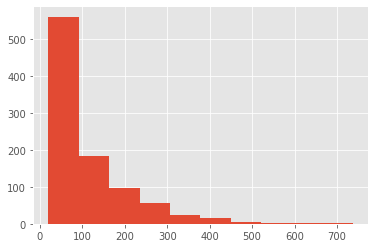

In [34]:
# 히스토그램
plt.style.use('ggplot')
movie_lens.groupby('uid').size().sort_values(ascending=False).hist()

# 사용자의 평가 횟수에 대한 성향
# 빈도가 점점 낮아진다. -> 길게 꼬리르 늘어뜨리는 모양 -> 롱테일분포
# "지프의 법칙"을 따른 굴곡 모양이다.
# 영화의 평가가 많으면, 그 사용자들 중에는 1회성 평가 횟수도 많다.

'''
Star Wars (1977)                 583
스타워즈 1977년 작품에 평가가 583회 수행되었는데, 이중에는 이 영화만 평가한 유저도
다수 존재한다.(현 데이터에서는 최저 평가 횟수가 사용자당 20)
'''

In [35]:
# 사용자별 평가 횟수, 평균
user_state = movie_lens.groupby('uid').agg({'rating': [np.size, np.mean]})
user_state.head()

rating          
      size      mean
uid                 
1      272  3.610294
2       62  3.709677
3       54  2.796296
4       24  4.333333
5      175  2.874286

In [36]:
user_state.shape

(943, 2)

In [37]:
user_state.describe()

# 최저값 : 1.49, 최대값 : 4.87, 25%~75% : 3점대로 몰려있다.
# 평균 : 3.58 -> 어떤 영화든지 일반적으로 3점 이상은 받는다.
# 3점 이하는 영화 자체에 문제가 있어 보인다.
# 최고, 최저는 편중되어 있다.

rating            
             size        mean
count  943.000000  943.000000
mean   106.044539    3.588191
std    100.931743    0.445233
min     20.000000    1.491954
25%     33.000000    3.323054
50%     65.000000    3.620690
75%    148.000000    3.869565
max    737.000000    4.869565

### 5. 예측 모델 구축(머신러닝 기반)

- 알고리즘 -> 인수분해머신 기능을 제공하는 FastFM이라는 모듈 사용
- FastFM
    - C++로 만들어진 libFM이라는 알고리즘을 래핑
    - libFM을 python으로 구성한 것이 FastFM
    - 기능
        - 행렬 인수분해라는 기능을 일반화하여서 제공 -> 차원 축소
        - 범주형 변수를 파생변수로 변환하여 범주간의 상호 작용성을 계산
        - 특징 간 영향을 주고 받은 상호 작용 개념을 계산

- FastFM 제공 알고리즘
    - ALS : 교대 최소 제곱법
        - 장점 : 예측시간 빠름, SGD에 비해 하이퍼 파라미터가 작다.
        - 단점 : 규제처리가 필요
    - SGD : 확률적 경사 하강법
        - 장점 : 예측시간 빠름, 빅데이터를 빠르게 처리학습 할 수 있다.
        - 단점 : 하이퍼 파라미터가 많다, 규체처리가 필요
    - MCMC : 마르코프 연쇄 몬테카를로
        - 장점 : 하이퍼 파라미터가 작다, 자동규제
        - 단점 : 학습시간이 느리다

In [ ]:
# 아마존 EC2 서버에 접속하였다.
# febric3을 이용하여 이하 과정을 자동화 할 수 있다.

# 리눅스 상에서 루트 권한 획득
$ sudo su

# 리눅스의 현재 설치된 패키지 등을 최신으로 업그레이드
$ apt-get update && apt-get -y upgrade

# 패키지 설치(파이썬이 설치되어 있으면 파이썬 부분은 제외)
$ apt-get -y install python3-dev python3-pip git nano wget unzip libopenblas-dev

# 파이썬이 있으면 이하만 설치
$ apt-get -y install python3-pip git nano wget unzip libopenblas-dev

# fastFM 소스 다운로드
$ git clone --recursive https://github.com/ibayer/fastFM.git
$ cd fastFM

# 컴파일을 수행하기 전에 python 모듈 설치
# 내용 확인
$ cat requirements.txt
$ pip3 install -r ./requirements.txt

# 컴파일 -> 마지막 부분에 error가 보여도 무시
$ PYTHON=python3 make

# fastFM 설치
$ pip3 install .

# 확인
$ python3
>>> from fastFM import als
>>> exit()

# 개발에 필요한 패키지 설치
$ pip3 install pandas matplotlib jupyter

# (옵션)삭제
$ rm -r -f 폴더명

# 주피터 가동
$ cd ..
$ mkdir dev && cd dev
$ jupyter notebook --ip=0.0.0.0 --port=8888 --allow-root --no-browser
$ jupyter notebook --ip=0.0.0.0 --allow-root --no-browser

# 백그라운드에서 주피터 가동
$ nohup jupyter-notebook --ip=0.0.0.0 --port=8888 --allow-root --no-browser 1>/dev/null 2>&1 &

# 만약 토큰이 궁금하면
$ jupyter-notebook list
Currently running servers:
http://0.0.0.0:8888/?token=5367a490fd597ea07a79a704c4392edd52de7d13d5e914e0 :: /home/ubuntu/dev

# 터미널 닫아도됨

# 향후 백그라운드에서 주피터 죽이기
$ ps -e
---------------------------------------
 7127 pts/0    00:00:00 jupyter-noteboo
---------------------------------------
# 프로세스 목록에서 jupyter-notebook를 찾아서
$ kill -9 7127

- 여기서부터는 리눅스에서 운용되므로 현 파일은 종료
    - 단, 리눅스 서버에서 주피터를 새로 가동했으면 토큰은 신규로 입력해야 한다.
http://52.78.182.11:8888

In [39]:
from sklearn.feature_extraction import DictVectorizer
import numpy as np

In [40]:
# DictVectorizer : 문자열만 벡터화 처리
v = DictVectorizer()

In [41]:
# 더미 데이터
# 사용자 ID, 사용자가 평가한 영화 ID, 사용자의 나이
train = [
    {'uid': '1', 'mid': '5', 'age': 19},
    {'uid': '2', 'mid': '55', 'age': 33},
    {'uid': '3', 'mid': '20', 'age': 42},
    {'uid': '4', 'mid': '10', 'age': 20}
]

In [42]:
X = v.fit_transform(train)

# 수치는 그대로 배치, 문자열이 들어간 데이터는 벡터화로 처리
# 문자열은 범주형으로 보고 해당 케이스 별로 배치하여 0 혹은 1로 표시
X.toarray()

array([[19.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.],
       [33.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
       [42.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [43]:
# als를 이용해서 처리
from fastFM import als
from sklearn.model_selection import learning_curve

In [44]:
# 더미데이터 중 20살짜리 유저 1번은 영화 5번에 평점 5.0을 부여했다.
# 유저별로 부여한 평점
y = np.array([5.0, 1.0, 2.0, 4.0])

In [45]:
# als를 이용하여 fastFM의 회귀 모델을 초기화 후 학습을 진행
# 하이퍼 파라미터는 임시값 부여
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=2, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(X, y)

FMRegression(init_stdev=0.1, l2_reg=0, l2_reg_V=0.5, l2_reg_w=0.1, n_iter=1000,
             random_state=123, rank=2)

In [46]:
# 예측
# 새로운 유저가 신규 가입을 하였다. uid가 5번이 되었다.
# 나이가 24인 유저 5번이 영화 10번에 대해 내릴 평점을 예측해라.
# {'uid': '5', 'mid': '10', 'age': 24}
fm.predict(v.transform({'uid': '5', 'mid': '10', 'age': 24}))

array([3.49483358])

- 제공되는 데이터 ua.base, ua.test는 훈련용과 테스트용이 구분되어 있다.
- 이를 읽어서 자료구조를 만드는 형태로 처리하는 함수 구현

In [47]:
def loadData(fileName, path='./table/ml-100k/'):
    data = list()    # 학습용 데이터 형태
    y = list()       # 답안(평정)
    
    # 데이터 추출 및 구조 작업
    with open(path + fileName) as f:
        
        # 파일을 한 줄씩 읽음
        for line in f:
            
            # 데이터 한 줄을 구분해서 추출
            uid, mid, rating, ts = line.split('\t')
            
            # 유저아이디와 영화아이디 추가
            data.append({'uid': str(uid), 'mid': str(mid)})
            
            # 점수 추가
            y.append(float(rating))
            
    return data, np.array(y) 

# 훈련용 데이터 획득
train_data, y_train = loadData('ua.base')

In [49]:
len(train_data), len(y_train)

(90570, 90570)

In [50]:
# 테스트용 데이터 획득
test_data, y_test = loadData('ua.test')
len(test_data), len(y_test)

(9430, 9430)

In [51]:
# 해당 함수 확장 loadDataEx
# 평가에 참가한 유저들의 ID만 모은 데이터셋, 영화의 ID만 모은 데이터셋
def loadDataEx(fileName, path='./table/ml-100k/'):
    data = list()
    y = list()
    
    # 중복 데이터를 제거하는 자료구조 생성
    users = set()
    movies = set()
    
    with open(path + fileName) as f:
        for line in f:
            uid, mid, rating, ts = line.split('\t')
            
            data.append({'uid': str(uid), 'mid': str(mid)})
            y.append(float(rating))
            
            users.add(uid)
            movies.add(mid)
            
    return data, np.array(y), users, movies

In [52]:
# 훈련용 데이터 획득
train_data, y_train, train_users, train_movies = loadDataEx('ua.base')

# 테스트용 데이터 획득
test_data, y_test, test_users, test_movies = loadDataEx('ua.test')

In [53]:
# 훈련용 및 테스트용에 참가한 유저수는 동수
# 영화수는 훈련용이 테스트용보다 많다.
len(train_users), len(train_movies), len(test_users), len(test_movies)

(943, 1680, 943, 1129)

- 데이터의 벡터화 처리
- 사전에 데이터들을 다 문자로 처리했다.
- 평점만 빼고 uid, mid 값은 현재 문자열이다.

In [54]:
# 확인
train_data[:1]

[{'uid': '1', 'mid': '1'}]

In [55]:
# 훈련용 데이터의 벡터화
X_train = v.fit_transform(train_data)
X_train.shape, type(X_train)

((90570, 2623), scipy.sparse.csr.csr_matrix)

In [56]:
# 테스트용 데이터의 벡터화
X_test = v.fit_transform(test_data)
X_test.shape

(9430, 2072)

In [57]:
# 표준편차 확인 -> 회귀에서 평가지수 -> 평균제곱근오차를 계산할 때 평가 잣대
np.std(y_train), np.std(y_test)

(1.1260664426539722, 1.120180145761465)

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
# 9:1 비율(임의 설정)
# random_state -> 항상 동일하게 데이터가 섞이게 하기 위해서
X_train, X_train_test, y_train, y_train_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [60]:
X_train.shape, X_train_test.shape

((81513, 2623), (9057, 2623))

- 데이터는 모두 준비되었다.
- 회귀 모델에 학습 및 예측을 수행하기 위해 데이터의 형태를 알고리즘에 맞춰서 구성하였다.

- 알고리즘 선택
    - mcmc
        - 학습 및 예측 수행
        - 시각화를 통해서 수렴해가는 과정 확인
        - 테스트 데이터를 이용한 성능 측정
            - 평균제곱근오차 및 손실함수를 이용하여 평가
        - 하이퍼 파라미터 활용(고정)하여 평점의 정규화 처리, 성능 평가
        - 기타 정보 추가

In [ ]:
# 6. 시스템 통합(서비스에 반영, OTT, 쇼핑몰 등 대상)